## Семинар 1 "Полносвязные нейронные сети"

ФИО:

Сим Роман Дмитриевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронной сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400/>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        self.W = np.random.randn(input_size, output_size) * 0.1
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        self.Y = X @ self.W + self.b
        return self.Y

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        dLdx = dLdy @ self.W.T
        
        return dLdx
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        self.W -= self.dLdW * learning_rate
        self.b -= self.dLdb * learning_rate

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [3]:
def check_gradient(func, X, gradient, eps = 1e-6):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    grad_X = np.zeros(X.shape)
    for i in range(grad_X.shape[0]):
        for j in range(grad_X.shape[1]):
            X[i, j] += eps
            f_plus = func(X)
            X[i, j] -= eps
            
            X[i, j] -= eps
            f_minus = func(X)
            X[i, j] += eps
            
            grad_X[i, j] = (f_plus - f_minus) / (2 * eps)
    
    return np.max(np.abs(gradient - grad_X))

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [4]:
np.random.seed(0)
X = np.array([
              [2, 1],
              [1, 2]
             ])

Y = np.array([[2],
              [1]])
l = Linear(2, 1)

def loss(W):
    l.W = W
    return np.sum((l.forward(X) - Y) ** 2)

prediction = l.forward(X)
dLdy = 2 * (prediction - Y)
l.backward(dLdy)
print(check_gradient(loss, l.W, l.dLdW))

4.66760852191328e-10


### Часть 3: Сигмоида

In [5]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.sigm_out = 1.0 / (1 + np.exp(-X))
        return self.sigm_out
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dLdX = dLdy * self.sigm_out * (1 - self.sigm_out)
        return dLdX
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [6]:
X = np.random.rand(2, 2)
sigm = Sigmoid()

def sigm_loss(X):
    l = sigm.forward(X)
    return np.sum(l ** 2)

l = sigm.forward(X)
dLdy = 2 * l
gradients = sigm.backward(dLdy)
print(check_gradient(sigm_loss, X, gradients))

1.4301893003221267e-10


### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [41]:
class NLLLoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''

        self.n_samples = X.shape[0] 
        self.n_classes = X.shape[1]
        self.Z = self.softmax(X)
        self.Y = self.n_log_likehood(y)
        L = self.cross_entropy(self.Z, self.Y)
        return L
    
    def softmax(self, X):
        max_xi = np.max(X)
        s_value = X - np.log(np.sum(np.exp(X - max_xi), axis=-1, keepdims=True)) - max_xi
        return np.exp(s_value)

    @staticmethod
    def cross_entropy(X, y):
        return -(np.log(X) * y).sum(1).mean(0)
    
    def n_log_likehood(self, y):
        n_log_likehood = np.zeros((self.n_samples, self.n_classes))
        n_log_likehood[np.arange(self.n_samples), y.T] = 1
        return n_log_likehood
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        dLdx = (self.Z - self.Y) / self.Y.shape[0]
        return dLdx

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [42]:
X = np.random.rand(10, 2)
y = np.random.randint(0, 2, 10)

L = NLLLoss()

def func(X):
    return L.forward(X,y)

l = L.forward(X, y)
gradients = L.backward()
print(check_gradient(func, X, gradients))

1.190402568185256e-10


### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [43]:
class MSELoss:
    def __init__(self):
        pass

    def forward(self, X, y):
        self.X = X
        self.y = y.reshape(y.shape[0],-1)
        return np.sum((self.X - self.y) ** 2) / self.X.shape[0]

    def backward(self):
        dLdx = 2 * (self.X - self.y) / self.y.shape[0]
        return dLdx

In [44]:
class NeuralNetwork:
    def __init__(self, modules):
        self.layers = list(modules)
    
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for layer in self.layers[::-1]:
            dLdy = layer.backward(dLdy)
    
    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

### Часть 6, обучение на простых данных

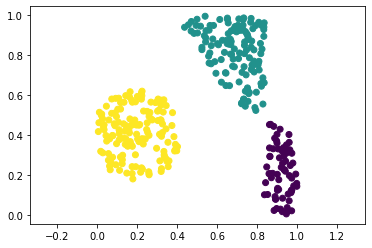

In [45]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

In [46]:
nn = NeuralNetwork([
    Linear(2, 10),
    Sigmoid(),
    Linear(10, 10),
    Sigmoid(),
    Linear(10, 3),
])
loss = NLLLoss()

losses = []
NUM_EPOCHS = 30000
for epoch in range(NUM_EPOCHS):
    predictions = nn.forward(X)
    L = loss.forward(predictions, y)
    losses.append(L)
    dLdy = loss.backward()
    nn.backward(dLdy)
    nn.step(0.38)

# Minimal loss = 0.00023879490637163572

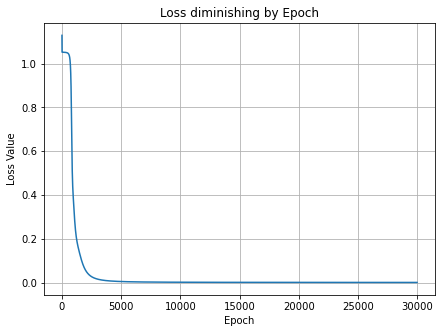

Minimal loss = 0.0002542355929039414


In [47]:
plt.figure(figsize=(7, 5))
plt.plot(losses)
plt.title("Loss diminishing by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.grid(True)
plt.show()
print(f"Minimal loss = {losses[-1]}")

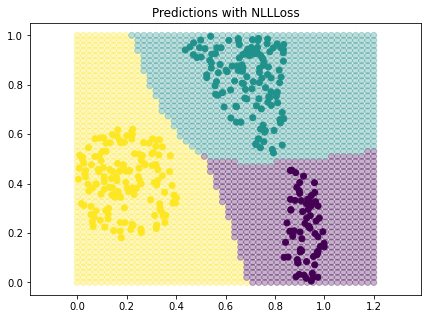

In [48]:
N_mesh = 50
x_grid = np.linspace(0.0, 1.2, N_mesh)
y_grid = np.linspace(0, 1, N_mesh)

X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

mesh = np.dstack((X_mesh, Y_mesh)).reshape(N_mesh * N_mesh, 2)
predictions = np.argmax(nn.forward(mesh), 1)

plt.figure(figsize=(7, 5))
plt.title("Predictions with NLLLoss")
plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость? - При выборе темпа обучения в 0.038, на 30000 эпохе потери сводятся практически к нулю

Отличная визуализация: http://playground.tensorflow.org/

## Домашнее задание:

* Подберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность? - Да.

In [49]:
np.linspace(0.005, 0.5, 20)

array([0.005     , 0.03105263, 0.05710526, 0.08315789, 0.10921053,
       0.13526316, 0.16131579, 0.18736842, 0.21342105, 0.23947368,
       0.26552632, 0.29157895, 0.31763158, 0.34368421, 0.36973684,
       0.39578947, 0.42184211, 0.44789474, 0.47394737, 0.5       ])

In [54]:
rates = np.linspace(0.05, 0.5, 20)
nn = NeuralNetwork([
    Linear(2, 10),
    Sigmoid(),
    Linear(10, 10),
    Sigmoid(),
    Linear(10, 3),
])
loss = MSELoss()

losses = []
NUM_EPOCHS = 30000
for rate in rates:
    loss_ = loss
    for epoch in range(NUM_EPOCHS):
        predictions = nn.forward(X)
        L = loss_.forward(predictions, y)
        # losses.append(L)
        dLdy = loss_.backward()
        nn.backward(dLdy)
        nn.step(rate)
    losses.append(L)

# Minimal loss = 0.00023879490637163572

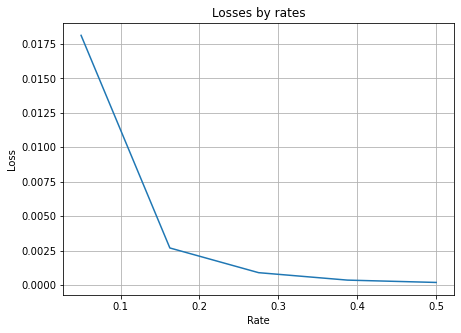

Minimal loss = (0.0001868304295099518, 0.5)


In [55]:
plt.figure(figsize=(7, 5))
plt.plot(rates, losses)
plt.title("Losses by rates")
plt.xlabel("Rate")
plt.ylabel("Loss")
plt.grid(True)

plt.show()
min = [1, 1]
for i, x in enumerate(losses):
    if x < min[0]:
        min[0] = x
        min[1] = rates[i]
print(f"Minimal loss = {min[0], min[1]}")
# Minimal loss = 7.801999805648416e-05

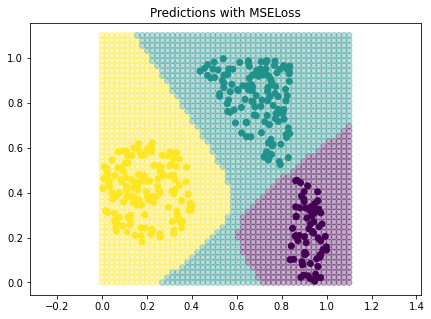

In [56]:
N_mesh = 50
x_grid = np.linspace(0, 1.1, N_mesh)
y_grid = np.linspace(0, 1.1, N_mesh)

X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

mesh = np.dstack((X_mesh, Y_mesh)).reshape(N_mesh * N_mesh, 2)
predictions = (np.rint(nn.forward(mesh)))[:, 0]


plt.figure(figsize=(7, 5))
plt.title("Predictions with MSELoss")
plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()